# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [5]:
# Display sample data
df.head()

,AGG,SPY
,close,close
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [6]:
# Calculate the daily roi for the stocks

# Display sample data

daily_returns = df.pct_change()
daily_returns.head()

,AGG,SPY
,close,close
2019-01-02 00:00:00-05:00,NaN,NaN
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844


In [7]:
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
print(f"avg_daily_return_spy = {avg_daily_return_spy}; avg_daily_return_agg = {avg_daily_return_agg}")

avg_daily_return_spy = 0.0010401250682146959; avg_daily_return_agg = 0.00021277231473764173


In [8]:
# Compute daily volatility

std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
print(f"std_dev_daily_return_spy = {std_dev_daily_return_spy}; std_dev_daily_return_agg = {std_dev_daily_return_agg}")

std_dev_daily_return_spy = 0.007820053413439366; std_dev_daily_return_agg = 0.002089826211646555


In [9]:
# Save the last day's closing price

spy_last_price = df['SPY']['close'][-1]
agg_last_price = df['AGG']['close'][-1]
print(f"spy_last_price = {spy_last_price}; agg_last_price = {agg_last_price}")

spy_last_price = 321.92; agg_last_price = 112.37


In [10]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
simulated_prices = pd.DataFrame()

In [25]:
# Running the Monte Carlo Simulation

for x in range(number_simulations):
 
    #Initiating SPY and AGG simulated prices with last closing price
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    
    for y in range(number_records):
        #Calculating simulated price of SPY and AGG using last price and append to their respective list
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_agg_prices.append(simulated_agg_price)
    
    #Appending simulated prices in the simulation dataframe
    simulated_prices["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_prices["AGG prices"] = pd.Series(simulated_agg_prices)
    
    # Calculating the daily returns of simulated prices
    simulated_daily_returns = simulated_prices.pct_change()
    
    # Setting the portfolio weights (60% SPY; 40% AGG) and apply to portfolio
    weights = [0.6, 0.4]
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculating the normalized, cumulative return series
    monte_carlo[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Printing top records of cumulative returns data frame
monte_carlo.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
7556,315.227869,142.213843,277.750067,267.384220,218.958475,187.980722,311.102506,148.006662,210.806321,350.686894,...,162.170812,205.931781,165.225026,77.245575,217.881955,281.673398,164.077153,199.785943,189.893597,271.153709
7557,316.085941,142.131192,280.110631,266.300793,218.852655,189.942933,308.942998,148.970533,210.003351,352.107982,...,162.719931,206.138273,164.842042,77.275292,218.025563,280.958028,164.575049,198.438086,189.405534,273.357070
7558,314.347415,142.981753,279.707404,266.963232,219.831358,190.558105,307.031986,148.563745,210.070076,353.123587,...,162.926808,207.545207,164.717865,77.576389,217.580496,280.752767,163.586633,199.476633,190.197074,273.440659
7559,313.169941,143.583776,280.579256,266.621254,219.123053,191.845169,308.041929,149.811959,211.948262,351.347016,...,162.115257,207.014606,165.196908,77.342240,215.582483,281.354117,164.796684,200.287875,190.565449,274.426144
7560,312.988957,144.711581,283.009654,265.593084,220.256403,194.112783,306.750684,149.945449,212.391031,352.520894,...,162.364040,207.395961,164.972361,77.323464,216.558776,280.928372,163.617271,199.214203,191.690804,275.269303


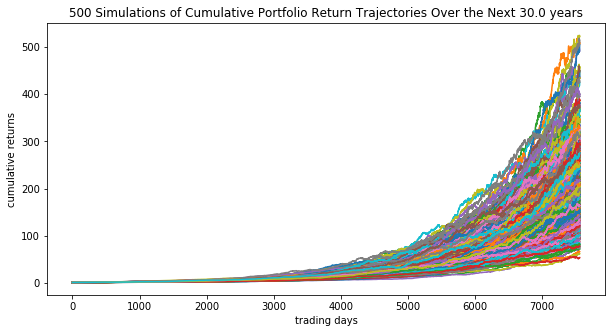

In [28]:
# Visualize the Simulation

plot_title = f"{x+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next {number_records/252} years"
monte_carlo_simulation = monte_carlo.plot(legend=None, title=plot_title,figsize=(10,5))
monte_carlo_simulation.set_xlabel("trading days")
monte_carlo_simulation.set_ylabel("cumulative returns")
monte_carlo_simulation

In [33]:
# Save figure

monte_carlo_simulation.figure.savefig('monte_carlo_simulation_30_years')

In [34]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)

ending_cumulative_returns = monte_carlo.iloc[-1, :]
ending_cumulative_returns.min(),ending_cumulative_returns.max()

(53.427559469254085, 522.4208763468773)

In [35]:
# Display the 90% confidence interval for the ending returns

confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05     94.917270
0.95    365.378239
Name: 7560, dtype: float64

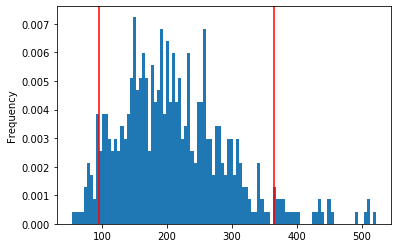

In [36]:
# Visualize the distribution of the ending returns

plt.figure();
x90_conf_int = ending_cumulative_returns.plot(kind='hist', density=True, bins=100)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [37]:
# Save figure

x90_conf_int.figure.savefig('90_percent_conf_interval')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [38]:
# Compute cumulative returns

ending_cumulative_returns.quantile(q=[0.1, 0.5,0.9])

0.1    109.408912
0.5    200.567754
0.9    311.555580
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [39]:
# Set initial investment

# Compute expected portfolio return

initial_investment = 20000
ending_cumulative_returns.quantile(q=[0.1, 0.5,0.9])*initial_investment

0.1    2.188178e+06
0.5    4.011355e+06
0.9    6.231112e+06
Name: 7560, dtype: float64

### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [40]:
# Set Plaid's projected income

# Calculate the 4% withdrawal for the ending return as retirement income

# Determine if the retirement income meets or exceeds the current projected income

retirement_income = 0.04 * (initial_investment * ending_cumulative_returns.quantile(.1))
retirement_income

87527.12982035022

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [41]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount

initial_investment = initial_investment * 1.5
retirement_income = 0.04 * (initial_investment * ending_cumulative_returns.quantile(.1))
retirement_income

131290.69473052534

### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [43]:
# Compute projected returns

# Display sample data

x5_percentiles = []
x50_percentiles = []
x95_percentiles = []
cumulative_returns = pd.DataFrame()

for z in range(number_records+1):
   
    #Calculate 5%, 50% and 90% quantile and append to respective series
    x5_percentile = monte_carlo.iloc[z, :].quantile(0.05)
    x5_percentiles.append(x5_percentile)
    x50_percentile = monte_carlo.iloc[z, :].quantile(0.50)
    x50_percentiles.append(x50_percentile)
    x95_percentile = monte_carlo.iloc[z, :].quantile(0.95)
    x95_percentiles.append(x95_percentile)
    
#Append simulated prices in the simulation dataframe
cumulative_returns["0.05 Quantile"] = pd.Series(x5_percentiles)
cumulative_returns["0.50 Quantile"] = pd.Series(x50_percentiles)
cumulative_returns["0.95 Quantile"] = pd.Series(x95_percentiles)

# Print bottom records of cumulative returns data frame
cumulative_returns.tail()

,0.05 Quantile,0.50 Quantile,0.95 Quantile
7556,95.209842,200.998711,363.664790
7557,95.658591,200.822983,363.505149
7558,95.314602,200.798531,364.798740
7559,95.046688,200.551791,363.838667
7560,94.917270,200.567754,365.378239


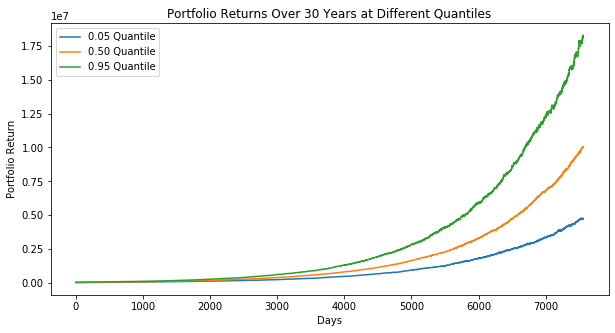

In [44]:
# Plot the cumulative returns over time


Quantile = (cumulative_returns*50000).plot(figsize=(10,5),title ="Portfolio Returns Over 30 Years at Different Quantiles")
Quantile.set_xlabel("Days")
Quantile.set_ylabel("Portfolio Return")
Quantile